Description: Detect edge & evaluate FOM of proposed method with various noise level

Python version: 3.9

In [1]:
# %% Import libraries
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io  # v.0.18.1
from skimage.filters import median
from skimage.morphology import disk
from pathlib import Path
from os import sep

In [2]:
from cv2 import morphologyEx, MORPH_OPEN 

In [3]:
from cpseg_functions import \
    ak_get_filename, add_noise, ak_rotate_edge_overlay, ak_post_process, \
    ak_edge_eval

In [4]:
# %% Parameters
#imagefile_id = 0  #6                           # id of image file in the folder, i
#noisedensity_id = 0                            # Salt & pepper noise id, k
noisedensity = [0, 0.05, 0.1, 0.4, 0.6, 0.9]    # Salt & pepper noise level list
se_size = 200                                   # Background subtraction
medianValue = [5, 5]#[30, 30]                   # Median filter
y_interval = 2  # 5                             # Sparse scan along y-axis, pixel
rotation_angle = 4 #3                           # 0: 45 degree, 3: semicircle
                                                # 1: 30 degree, 4: semicircle
                                                # 2: 15 degree, 5: semicircle
changepoint_algo = 1                            # 0: number known, 1: number not known
numBorder = 4                                   # Number of change points,
                                                # if changepoint_algo = 1, use PELT for panelized detection
penalty_value = 250000 #100000                  # Penalty cost when numBorder = 0
numlayer = 1                                    # 0: single <- avoid in this workflow
                                                # 1: overlay multiple
model = "linear"                                # "rbf", "linear", "cosine"
postprocess = 1                                 # 0: no, 1:yes
smallNoiseRemov = 1                             # 0:No noise removal
                                                # 1:Connect border, then remove small noises
                                                # 2:Remove small noisess first, then connect
senoise = y_interval * 2                        # Structural element size of morphology opening:default:5
neib = 25                                       # Remove small objects less than neib(pixel) default:100
select_biggest = 0                              # 0: No selection; 1: select biggest
nskeletonize = 1                                # 0: No skeletonization, 1: with skeletonization
evaluation = 1                                  # 0: No evaluation, 1: With evaluation

In [5]:
# Select image
print("Input image file id (0-8).")
imagefile_id = np.asarray(input(),dtype=int)
print("Image file id is:", imagefile_id)

Input image file id (0-8).


 0


Image file id is: 0


In [6]:
# Select noise level
print("Input noise level id of salt&pepper noise (0-5).")
noisedensity_id = np.asarray(input(),dtype=int)
print("Noisedensity is: ", noisedensity[noisedensity_id])

Input noise level id of salt&pepper noise (0-5).


 0


Noisedensity is:  0


Image number is 0.
Salt & pepper noise density id is 0.
Edge detected.
Postprocessing done.
Pratt's FOM: 55.081850023147084


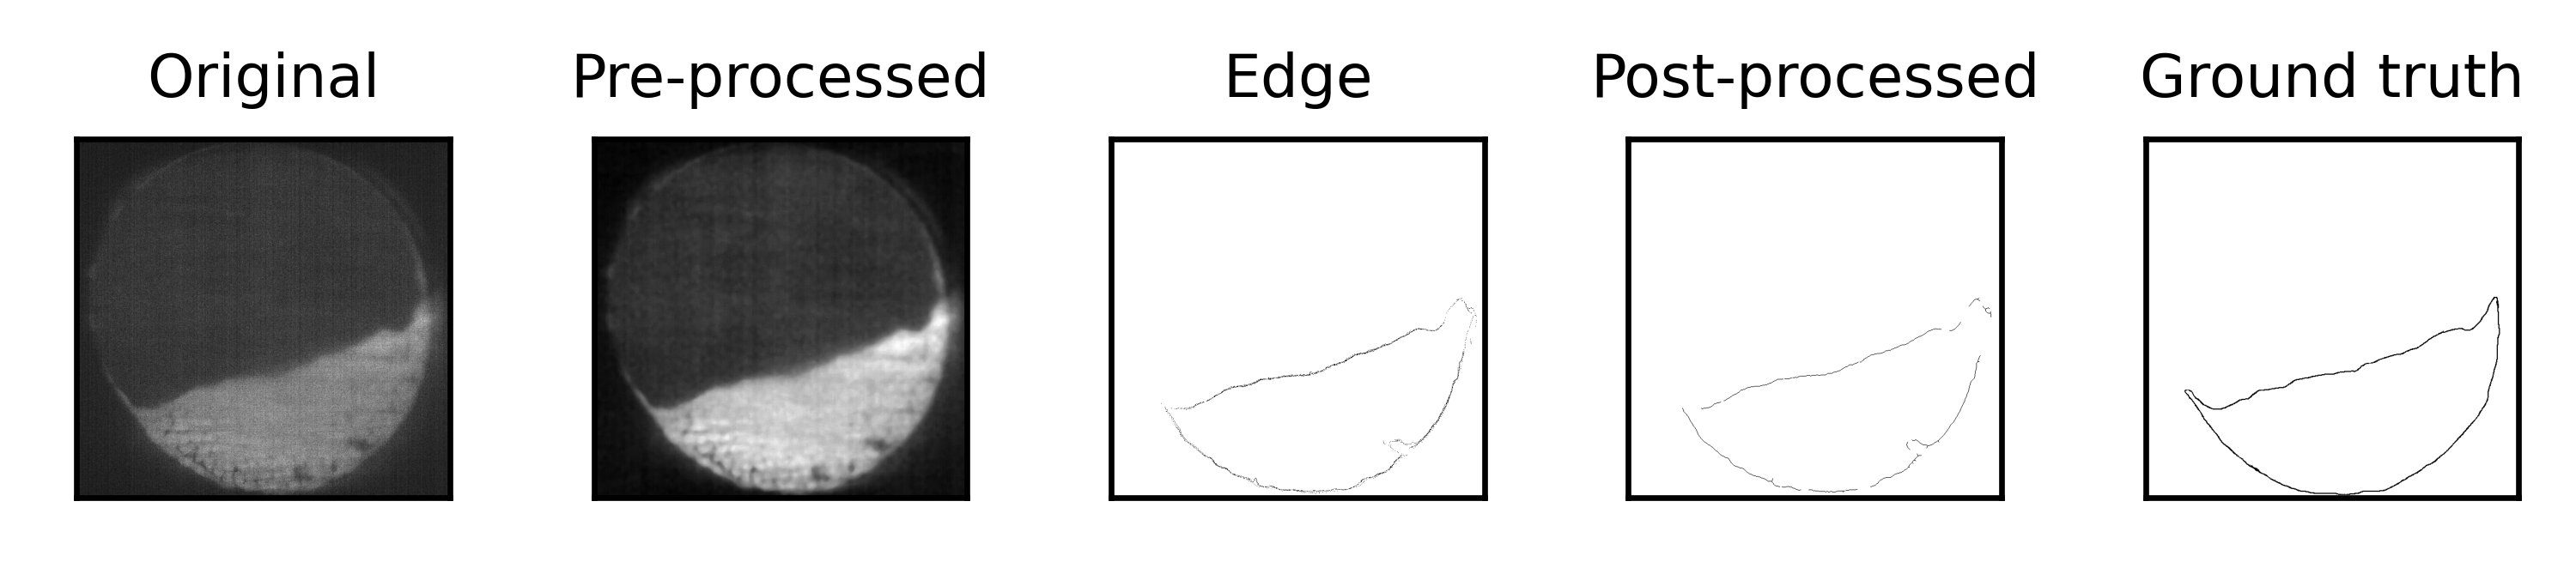

In [7]:
# %% Processing
# Specify directories
imDir = f"examples{sep}images{sep}"
gtDir = f"examples{sep}groundtruth{sep}"
# Get image file name
imFilename = ak_get_filename(imDir)
# Set result containers
nImFile = np.size(imFilename)
nNoiseDensity = np.size(noisedensity)
fom_array = np.zeros((nImFile, nNoiseDensity))
mse_array = np.zeros((nImFile, nNoiseDensity))
# Detect borders using the proposed method & calculate FOM & MSE
I0 = io.imread(imFilename[0])
I0 = np.array(I0)
BW_final = np.zeros(I0.shape)  # empty border object
i = imagefile_id  # image file id, for all files in the folder # for i in np.arange(0,nImFile - 1, 1):
print(F'Image number is {i}.'.format(i=i))
Iori = io.imread(imFilename[i])  # Load image
Iori = np.array(Iori)

gtPath = gtDir + Path(imFilename[i]).stem + '_gt.tif'   # Path to ground truth
BWgt = io.imread(gtPath)                                # Load ground truth
BWgt = np.array(BWgt)

#%% Edge detection
# Add salt & pepper noise
k = noisedensity_id                                         # Noise level; for multi k values: for k in np.arange(0, nNoiseDensity - 1, 1):
print(F'Salt & pepper noise density id is {k}.'.format(i=i))
Inoise = add_noise(Iori, noisedensity[k])                   # Add salt & pepper noise
# Pre-processing
se_imopen = disk(se_size)                                   # structrul element for morph open
background = morphologyEx(Inoise, MORPH_OPEN, se_imopen)    # opening
I_bg = Inoise - background                                  # Subtract background
Ien = median(I_bg, footprint=disk(medianValue[0]))          # Smoothing filter
# Edge detection w/ proposed methow
# Rotate & detect edge
BW = ak_rotate_edge_overlay\
    (Ien,numlayer,rotation_angle,numBorder,model,y_interval,penalty_value, changepoint_algo)
print('Edge detected.')

# Post-processing
if postprocess == 1:
    BWlast = ak_post_process\
        (BW,smallNoiseRemov,senoise,neib,select_biggest,nskeletonize)
    print('Postprocessing done.')
elif postprocess == 0:
    BWlast = BW
    print('Postprocessing omitted.')
else:
    print("'postprocess' should be either '0' or '1'.")

# Cancatenate layers
if BW_final.ndim == 2:
    #BW_final = np.stack([BW_final, BWlast],axis=0)
    BW_final = BWlast
elif BW_final.ndim == 3:
    BWlast_r = BWlast.reshape(1,BWlast.shape[0],BWlast.shape[1])
    BW_final = np.concatenate((BW_final, BWlast_r),axis=0)

#%% Calculate FOM & MSE
if evaluation == 0:
    print("Pratt's FOM: Not evaluated")
if evaluation == 1:
    score = ak_edge_eval(BWgt,BWlast)
    # Save FOM & MSE as array
    fom_array[i,k] = score['fom']
    mse_array[i,k] = score['mse']
    print(f"Pratt's FOM: {fom_array[i,k]}")

#Show results
fig, ax = plt.subplots(1,5, constrained_layout = True, figsize=(5, 1), dpi=600) # figsize: figure dimension (width, height) in inches.
ax[0].imshow(Iori, cmap='gray')
ax[0].set_title('Original',fontsize='small')
ax[1].imshow(Ien, cmap='gray')
ax[1].set_title('Pre-processed',fontsize='small')
ax[2].imshow(BW, cmap='gray_r')
ax[2].set_title('Edge',fontsize='small')
ax[3].imshow(BWlast, cmap='gray_r')
ax[3].set_title('Post-processed',fontsize='small')
ax[4].imshow(BWgt, cmap='gray_r')
ax[4].set_title('Ground truth',fontsize='small')
for i in np.arange(0,5):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()